# DATA SOURCE

Mall customer

url : https://www.kaggle.com/datasets/amisha0528/mall-customers-dataset

In [101]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.stats as ss


# data load
customer_data = pd.read_csv('Mall_Customers.csv')

# selecting features
features = customer_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# check data
print(customer_data.describe())


       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


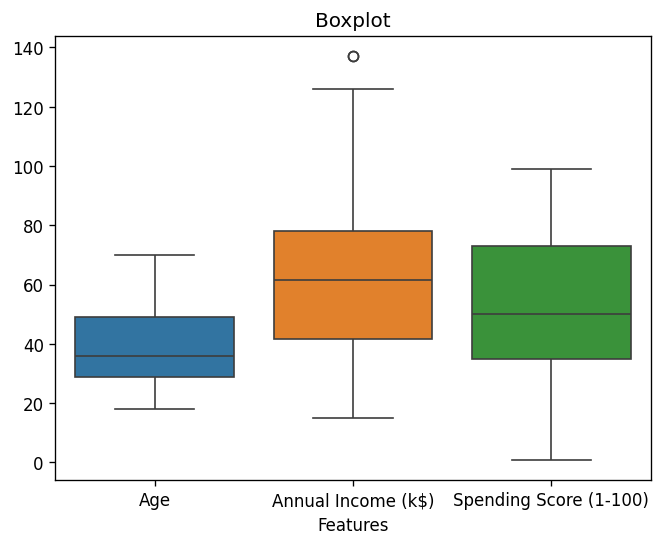

In [102]:
def plot_box(data):
  """
  plot a box chart
  """
  plt.figure(dpi=120)
  sns.boxplot(data)
  plt.xlabel('Features')
  plt.title('Boxplot')
  plt.show()
  return

# execute function
plot_box(customer_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])


In [103]:
def print_stats(dist):
  """
  print moments of distributon
  """
  print(f'mean : {np.mean(dist):.2f} +/- {ss.bootstrap((dist,), np.mean, confidence_level=0.682).standard_error:.2f}')
  print(f'std : {np.std(dist):.2f} +/- {ss.bootstrap((dist,), np.std, confidence_level=0.682).standard_error:.2f}')
  print(f'skew : {ss.skew(dist):.2f} +/- {ss.bootstrap((dist,), ss.skew, confidence_level=0.682).standard_error:.2f}')
  print(f'kurtosis : {ss.kurtosis(dist):.2f} +/- {ss.bootstrap((dist,), ss.kurtosis, confidence_level=0.682).standard_error:.2f}')
  return

# print statistics moments for each dist
for col_name in features.columns:
    dist = customer_data[col_name]
    print(col_name)
    print_stats(dist)
    print()

Age
mean : 38.85 +/- 0.99
std : 13.93 +/- 0.56
skew : 0.48 +/- 0.10
kurtosis : -0.68 +/- 0.18

Annual Income (k$)
mean : 60.56 +/- 1.87
std : 26.20 +/- 1.28
skew : 0.32 +/- 0.14
kurtosis : -0.13 +/- 0.26

Spending Score (1-100)
mean : 50.20 +/- 1.84
std : 25.76 +/- 0.98
skew : -0.05 +/- 0.09
kurtosis : -0.84 +/- 0.13



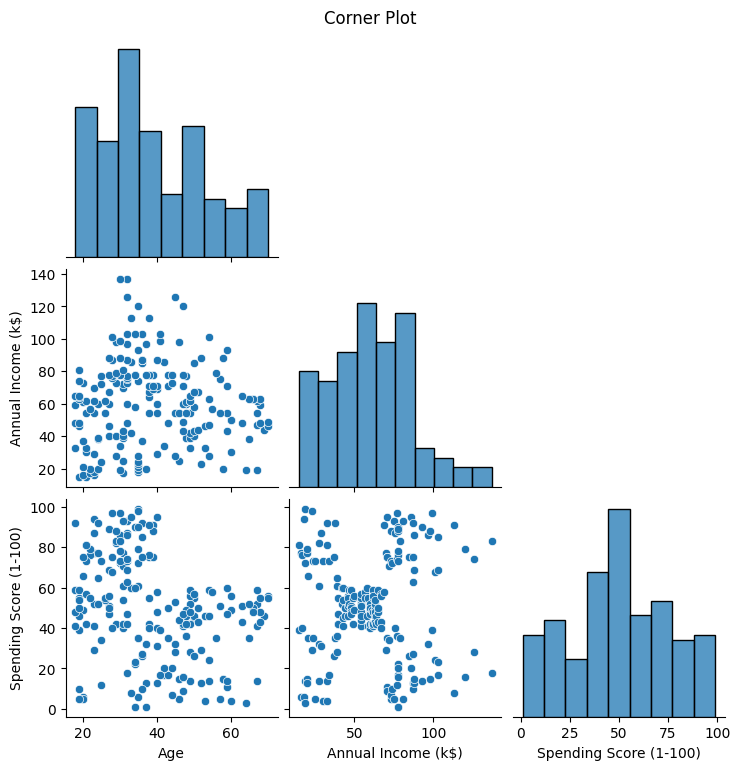

In [104]:
# corner plot
def plot_corner(data):
  """
  plot a corner plot
  """
  sns.pairplot(data, corner=True)
  plt.suptitle('Corner Plot', y=1.02)
  plt.show()


plot_corner(customer_data[features.columns])

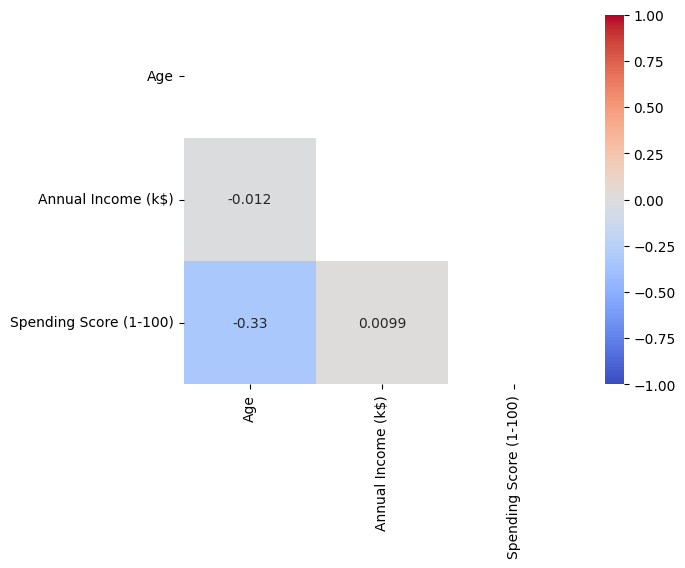

In [110]:
# Heatmap visulization
mask = np.triu(np.ones_like(customer_data[features.columns].corr()))
sns.heatmap(customer_data[features.columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.show()

In [111]:
# scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


def one_silhoutte_inertia(n, xy):
  """
  calulate the silhoutte score and WCSS for n clusters
  """
  kmeans = KMeans(n_clusters=n, n_init=20)
  kmeans.fit(xy)
  score = silhouette_score(xy, kmeans.labels_)
  inertia = kmeans.inertia_
  return score, inertia

# Determine optimal number of clusters using silhouette score
wcss = []
best_n, best_socre = None, -np.inf
for n in range(2, 11):
  score, inertia = one_silhoutte_inertia(n, features_scaled)
  wcss.append(inertia)
  if score > best_socre:
    best_socre = score
    best_n = n
  print(f'{n} clusters silhoutte score: {score:.4f}')

print(f'best number fo cluster is {best_n}')

2 clusters silhoutte score: 0.3355
3 clusters silhoutte score: 0.3578
4 clusters silhoutte score: 0.4040
5 clusters silhoutte score: 0.4166
6 clusters silhoutte score: 0.4274
7 clusters silhoutte score: 0.4172
8 clusters silhoutte score: 0.4075
9 clusters silhoutte score: 0.4089
10 clusters silhoutte score: 0.4023
best number fo cluster is 6


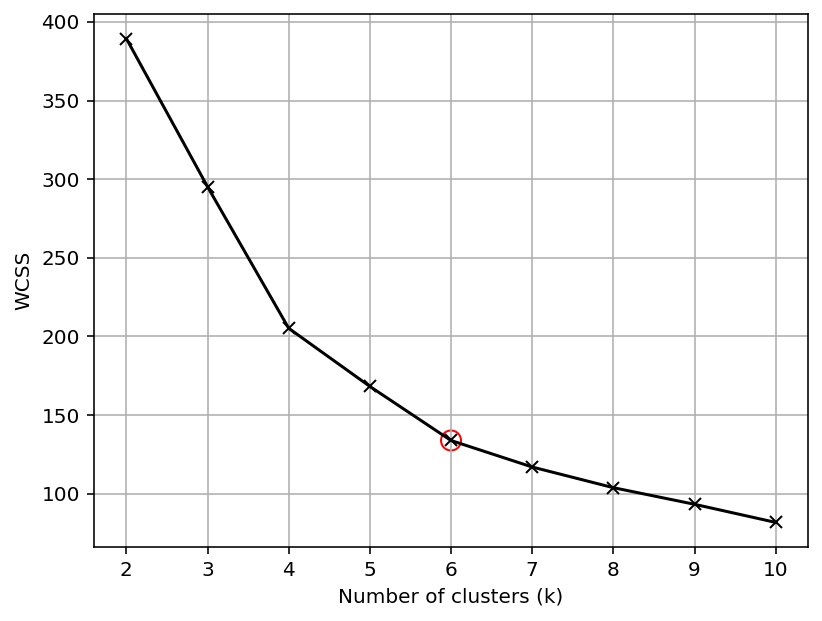

In [112]:
# Elbow Method graph
def plot_elbow_method(min_k, max_k, wcss, best_n):
    fig, ax = plt.subplots(dpi=144)
    ax.plot(range(min_k, max_k + 1), wcss, 'kx-')
    ax.scatter(best_n, wcss[best_n - min_k], marker='o', color='red', facecolors='none', s=100)
    ax.set_xlabel('Number of clusters (k)')
    ax.set_ylabel('WCSS')
    ax.grid(True)
    plt.show()


plot_elbow_method(2, 10, wcss, best_n)

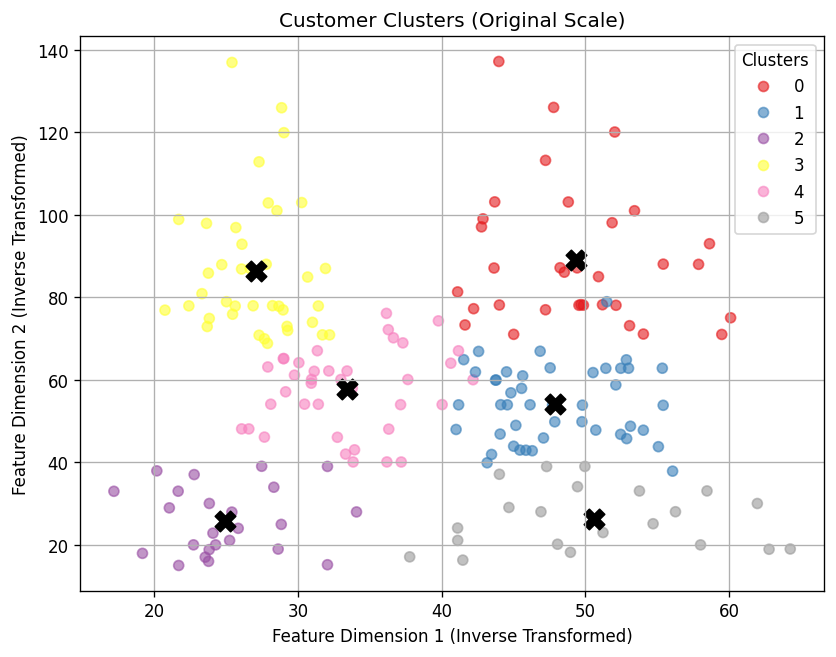

In [115]:
from matplotlib.colors import ListedColormap

def plot_cluster_fit_inverse(data_scaled, labels, scaler, title='Cluster Visualization (Inverse PCA)'):
    """
    Plot clusters with inverse PCA transformation.
    """
    # pca transformation
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(data_scaled)

    # clustering model fittig
    kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42, n_init=20)
    kmeans.fit(data_scaled)

    # trinsforming pca center
    centers_pca = pca.transform(kmeans.cluster_centers_)

    # inverse to plot
    features_inv = scaler.inverse_transform(pca.inverse_transform(features_pca))
    centers_inv = scaler.inverse_transform(pca.inverse_transform(centers_pca))

    # visulization
    plt.figure(figsize=(8, 6), dpi=120)
    scatter = plt.scatter(features_inv[:, 0], features_inv[:, 1], c=labels, cmap='Set1', alpha=0.6)
    plt.scatter(centers_inv[:, 0], centers_inv[:, 1], c='black', marker='X', s=150, label='Cluster Centers')

    plt.xlabel('Feature Dimension 1 (Inverse Transformed)')
    plt.ylabel('Feature Dimension 2 (Inverse Transformed)')
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.grid(True)
    plt.show()

# execute function
plot_cluster_fit_inverse(features_scaled, labels, scaler, title='Customer Clusters (Original Scale)')

               Age  Annual Income  Spending Score
cluster                                          
0        41.939394      88.939394       16.969697
1        56.333333      54.266667       49.066667
2        25.250000      25.833333       76.916667
3        32.692308      86.538462       82.128205
4        26.684211      57.578947       47.789474
5        45.523810      26.285714       19.380952


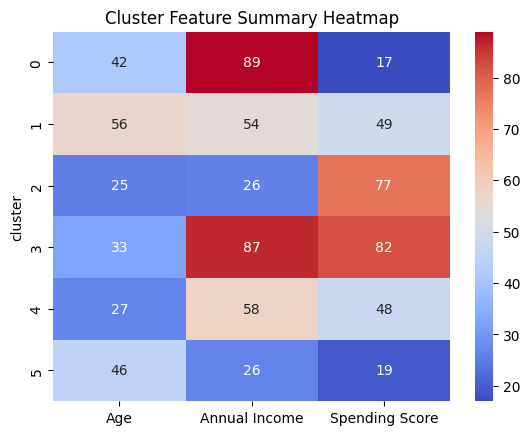

In [114]:
# Summarize cluster characteristics
customer_data['cluster'] = labels
cluster_summary = customer_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)','cluster']].groupby('cluster').mean()
cluster_summary.columns = ['Age', 'Annual Income', 'Spending Score']
print(cluster_summary)

# Heatmap for cluster characteristics
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm')
plt.title('Cluster Feature Summary Heatmap')
plt.show()